In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
sns.set()

os.chdir('../..')

DATA = Path('data')
RAW  = DATA/'raw'
PROCESSED = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [39]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)

In [42]:
proc_train = pd.read_feather(PROCESSED/'proc_train.feather')
proc_val = pd.read_feather(PROCESSED/'proc_val.feather')
proc_all = pd.read_feather(PROCESSED/'proc_all.feather')
proc_test = pd.read_feather(PROCESSED/'proc_test.feather')

/anaconda/envs/kaggle/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [30]:
len(proc_train), len(proc_val)

(79873, 53250)

In [47]:
from sklearn.model_selection import train_test_split
proc_train, proc_val = train_test_split(proc_all, test_size=0.15, random_state=504, shuffle=True)

In [48]:
proc_train, proc_val = proc_train.copy(), proc_val.copy()

In [49]:
len(proc_train), len(proc_val)

(113154, 19969)

## Get sequences

In [9]:
%%time
test_session = pd.read_csv('data/raw/random_submission.csv')
test_tracking = pd.read_csv('data/raw/test_tracking.csv')
train_session = pd.read_csv('data/raw/train_session.csv') 
train_tracking = pd.read_csv('data/raw/train_tracking.csv')
productid_category = pd.read_csv('data/raw/productid_category.csv')

CPU times: user 56.7 s, sys: 4.98 s, total: 1min 1s
Wall time: 1min 1s


In [11]:
all_tracking = pd.concat([train_tracking, test_tracking])
event_labels = {event: idx + 1 for idx, event in enumerate(all_tracking.type.unique())}
all_tracking['type_id'] = all_tracking.type.map(event_labels)
events_seq = all_tracking.groupby('sid')['type_id'].apply(list)

In [12]:
MAX_LEN = 30
def pad_seq(x):
    res = np.zeros(MAX_LEN).astype(int)
    res[max(0, MAX_LEN - len(x)):] = x[-MAX_LEN:]
    return res
events_fixed_seq = events_seq.apply(pad_seq)

In [10]:
def get_cat_seqs(events_fixed_seq, proc_train, proc_val):
    train_cat_seqs = events_fixed_seq[list(proc_train.sid)]
    val_cat_seqs = events_fixed_seq[list(proc_val.sid)]
    train_cat_seqs = np.stack(train_cat_seqs).reshape((-1, MAX_LEN, 1))
    val_cat_seqs = np.stack(val_cat_seqs).reshape((-1, MAX_LEN, 1))
    return train_cat_seqs, val_cat_seqs

In [56]:
train_cat_seqs, val_cat_seqs = get_cat_seqs(events_fixed_seq, proc_train, 
                                            proc_val)

In [22]:
import pickle
with open(PROCESSED/'f_sessionsmap_train.pkl', 'rb') as f:
    seqs_train_dict = pickle.load(f) 
with open(PROCESSED/'f_sessionsmap_test.pkl', 'rb') as f:
    seqs_test_dict = pickle.load(f) 

duration_seqs_train = np.load(PROCESSED/'f_duration_train.npy')
duration_seqs_test = np.load(PROCESSED/'f_duration_test.npy')
    
action_seqs_train = np.load(PROCESSED/'f_actions_train.npy')
action_seqs_test = np.load(PROCESSED/'f_actions_test.npy')

quantity_seqs_train = np.load(PROCESSED/'f_quantity_train.npy')
quantity_seqs_test = np.load(PROCESSED/'f_quantity_test.npy')

In [24]:
def get_cont_seqs(cont_seqs_train, cont_seqs_val, seqs_train_dict, seqs_val_dict, proc_train, proc_val):
    train_cont_seqs = np.concatenate([
        x[[seqs_train_dict[sid] for sid in proc_train.sid]] for x in cont_seqs_train
    ], axis=2)
    val_cont_seqs = np.concatenate([
        x[[seqs_val_dict[sid] for sid in proc_val.sid]] for x in cont_seqs_val
    ], axis=2)
    return train_cont_seqs, val_cont_seqs

In [50]:
train_cont_seqs, val_cont_seqs = get_cont_seqs([duration_seqs_train, 
                                 action_seqs_train,
                                 quantity_seqs_train], [duration_seqs_train,
                                 action_seqs_train, quantity_seqs_train],
                                 seqs_train_dict, seqs_train_dict, 
                                 proc_train, proc_val)

In [51]:
cat_cols = ['device', 'siteid']
target_col = 'target' 
id_col = 'sid'
cont_cols = [x for x in proc_train.columns if x not in cat_cols + [target_col, id_col]]

In [52]:
from src.utils_r import to_cat_codes, apply_cats

def process_cats(proc_train, proc_val, cat_cols):
    to_cat_codes(proc_train, cat_cols)
    apply_cats(proc_val, proc_train)
    for df in [proc_train, proc_val]:
        for col in cat_cols:
            df[col] = df[col].cat.codes
    proc_train['device'] = proc_train.device + 1
    proc_val['device'] = proc_val.device + 1

In [53]:
process_cats(proc_train, proc_val, cat_cols)

In [54]:
from sklearn.preprocessing import StandardScaler
def scale_conts(proc_train, proc_val, cont_cols):
    scaler = StandardScaler()
    scaler.fit(pd.concat([proc_train[cont_cols], proc_val[cont_cols]]))
    proc_train_cont_norm = scaler.transform(proc_train[cont_cols])
    proc_val_cont_norm = scaler.transform(proc_val[cont_cols])
    for i, col in enumerate(cont_cols):
        proc_train[col] = proc_train_cont_norm[:, i]
        proc_val[col] = proc_val_cont_norm[:, i]

In [55]:
scale_conts(proc_train, proc_val, cont_cols)

## Multimodal Net

In [57]:
from src.utils_r import MultimodalDataset
from torch.utils.data import DataLoader
ds_trn = MultimodalDataset(proc_train[cat_cols], proc_train[cont_cols],
                           train_cat_seqs, train_cont_seqs, proc_train[target_col])
ds_val = MultimodalDataset(proc_val[cat_cols], proc_val[cont_cols],
                           val_cat_seqs, val_cont_seqs, proc_val[target_col])

In [58]:
dl_trn = DataLoader(ds_trn, batch_size=128, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=128)

In [59]:
from src.utils_r import MultimodalNet

cat_szs = [int(proc_train[col].max() + 1) for col in cat_cols]
emb_szs = [(c, min(20, (c+1)//2)) for c in cat_szs]

n_cont = len(cont_cols)
emb_drop = 0.3
szs = [400, 200]
drops = [0.1, 0.1]

rnn_hidden_sz = 64
rnn_cont_sz = int(train_cont_seqs.shape[2])

rnn_cat_szs = [int(train_cat_seqs[:,:,0].max()+1)]
rnn_emb_szs = [(c, min(20, (c+1)//2)) for c in rnn_cat_szs]

rnn_n_layers = 2
rnn_drop = 0.2
lin_sz = 10
drop = 0.3
out_sz = 1

In [60]:
from src.utils_r import train_model
from torch import optim
import torch.nn as nn

In [61]:
USE_CUDA = True

In [62]:
model = MultimodalNet(emb_szs, n_cont, emb_drop, szs, drops, 
                      rnn_hidden_sz, rnn_cont_sz, rnn_emb_szs, 
                      rnn_n_layers, rnn_drop, lin_sz, drop, out_sz)
if USE_CUDA: model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

In [63]:
%%time
best_epoch = train_model(model, dl_trn, dl_val, optimizer, criterion, 
                         n_epochs=10, print_every=100, USE_CUDA=USE_CUDA)

Train Epoch: 1 [12800/113154 (11%)]	Loss: 0.611967
Train Epoch: 1 [25600/113154 (23%)]	Loss: 0.561949
Train Epoch: 1 [38400/113154 (34%)]	Loss: 0.526987
Train Epoch: 1 [51200/113154 (45%)]	Loss: 0.486262
Train Epoch: 1 [64000/113154 (56%)]	Loss: 0.452925
Train Epoch: 1 [76800/113154 (68%)]	Loss: 0.419992
Train Epoch: 1 [89600/113154 (79%)]	Loss: 0.394554
Train Epoch: 1 [102400/113154 (90%)]	Loss: 0.373659
Epoch: 1 | Train Logloss: 0.347921 | Val Logloss: 0.345479
Train Epoch: 2 [12800/113154 (11%)]	Loss: 0.348414
Train Epoch: 2 [25600/113154 (23%)]	Loss: 0.326421
Train Epoch: 2 [38400/113154 (34%)]	Loss: 0.317502
Train Epoch: 2 [51200/113154 (45%)]	Loss: 0.308997
Train Epoch: 2 [64000/113154 (56%)]	Loss: 0.303188
Train Epoch: 2 [76800/113154 (68%)]	Loss: 0.294177
Train Epoch: 2 [89600/113154 (79%)]	Loss: 0.296117
Train Epoch: 2 [102400/113154 (90%)]	Loss: 0.300090
Epoch: 2 | Train Logloss: 0.282041 | Val Logloss: 0.280219
Train Epoch: 3 [12800/113154 (11%)]	Loss: 0.299810
Train Epoch: 

## Test

In [64]:
train_cat_seqs, test_cat_seqs = get_cat_seqs(events_fixed_seq, proc_all, 
                                            proc_test)

In [65]:
train_cont_seqs, test_cont_seqs = get_cont_seqs([duration_seqs_train, 
                                 action_seqs_train,
                                 quantity_seqs_train], [duration_seqs_test,
                                 action_seqs_test, quantity_seqs_test],
                                 seqs_train_dict, seqs_test_dict, 
                                 proc_all, proc_test)

In [66]:
process_cats(proc_all, proc_test, cat_cols)

In [67]:
scale_conts(proc_all, proc_test, cont_cols)

## Net

In [68]:
from src.utils_r import MultimodalDataset
from torch.utils.data import DataLoader
ds_trn = MultimodalDataset(proc_all[cat_cols], proc_all[cont_cols],
                           train_cat_seqs, train_cont_seqs, proc_all[target_col])
ds_val = MultimodalDataset(proc_test[cat_cols], proc_test[cont_cols],
                           test_cat_seqs, test_cont_seqs, proc_test[target_col])

In [69]:
dl_trn = DataLoader(ds_trn, batch_size=128, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=128)

In [70]:
from src.utils_r import MultimodalNet

cat_szs = [int(proc_train[col].max() + 1) for col in cat_cols]
emb_szs = [(c, min(20, (c+1)//2)) for c in cat_szs]

n_cont = len(cont_cols)
emb_drop = 0.3
szs = [400, 200]
drops = [0.1, 0.1]

rnn_hidden_sz = 64
rnn_cont_sz = int(train_cont_seqs.shape[2])

rnn_cat_szs = [int(train_cat_seqs[:,:,0].max()+1)]
rnn_emb_szs = [(c, min(20, (c+1)//2)) for c in rnn_cat_szs]

rnn_n_layers = 2
rnn_drop = 0.2
lin_sz = 10
drop = 0.3
out_sz = 1

In [71]:
from src.utils_r import train_model
from torch import optim
import torch.nn as nn

In [72]:
USE_CUDA = True

In [75]:
model = MultimodalNet(emb_szs, n_cont, emb_drop, szs, drops, 
                      rnn_hidden_sz, rnn_cont_sz, rnn_emb_szs, 
                      rnn_n_layers, rnn_drop, lin_sz, drop, out_sz)
if USE_CUDA: model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

In [76]:
%%time
best_epoch = train_model(model, dl_trn, None, optimizer, criterion, 
                         n_epochs=10, print_every=100, USE_CUDA=USE_CUDA)

Train Epoch: 1 [12800/133123 (10%)]	Loss: 0.722378
Train Epoch: 1 [25600/133123 (19%)]	Loss: 0.651483
Train Epoch: 1 [38400/133123 (29%)]	Loss: 0.594915
Train Epoch: 1 [51200/133123 (38%)]	Loss: 0.540415
Train Epoch: 1 [64000/133123 (48%)]	Loss: 0.491261
Train Epoch: 1 [76800/133123 (58%)]	Loss: 0.447567
Train Epoch: 1 [89600/133123 (67%)]	Loss: 0.408602
Train Epoch: 1 [102400/133123 (77%)]	Loss: 0.375952
Train Epoch: 1 [115200/133123 (86%)]	Loss: 0.351008
Train Epoch: 1 [128000/133123 (96%)]	Loss: 0.329738
Epoch: 1 | Train Logloss: 0.308932
Train Epoch: 2 [12800/133123 (10%)]	Loss: 0.317913
Train Epoch: 2 [25600/133123 (19%)]	Loss: 0.311169
Train Epoch: 2 [38400/133123 (29%)]	Loss: 0.297267
Train Epoch: 2 [51200/133123 (38%)]	Loss: 0.299569
Train Epoch: 2 [64000/133123 (48%)]	Loss: 0.300926
Train Epoch: 2 [76800/133123 (58%)]	Loss: 0.280282
Train Epoch: 2 [89600/133123 (67%)]	Loss: 0.293594
Train Epoch: 2 [102400/133123 (77%)]	Loss: 0.281790
Train Epoch: 2 [115200/133123 (86%)]	Loss: 

In [78]:
%%time
from src.utils_r import eval_model
test_targets, test_preds = eval_model(model, dl_val, USE_CUDA=True)

CPU times: user 4.61 s, sys: 243 ms, total: 4.85 s
Wall time: 4.85 s


In [79]:
proc_test[target_col] = test_preds

In [80]:
proc_test[target_col].describe()

count    8.875000e+04
mean     9.243427e-02
std      9.766895e-02
min      7.892471e-32
25%      3.298490e-02
50%      5.245754e-02
75%      1.011425e-01
max      9.496264e-01
Name: target, dtype: float64

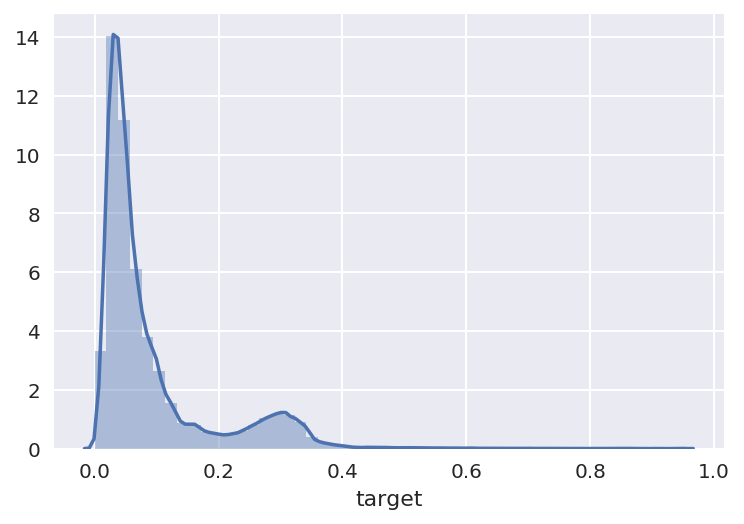

In [81]:
sns.distplot(proc_test[target_col])

In [82]:
proc_test[[id_col, target_col]].to_csv(SUBMISSIONS/'robert_4_submit.csv', index=False)

In [83]:
sub1 = pd.read_csv(SUBMISSIONS/'robert_0_submit.csv')

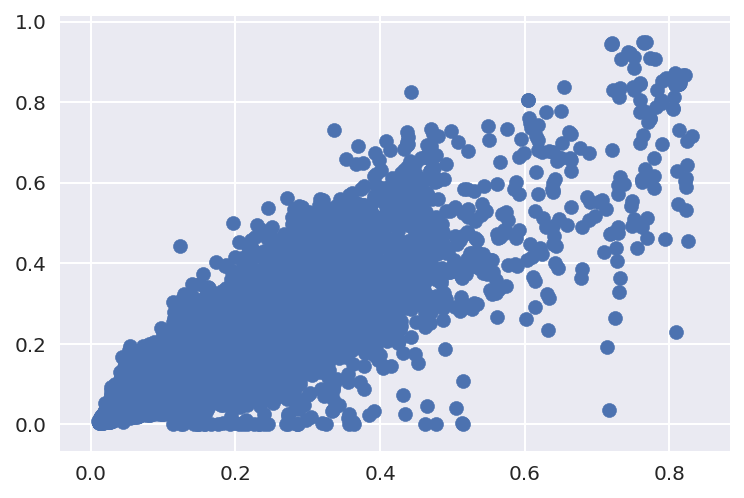

In [84]:
plt.scatter(sub1[target_col], proc_test[target_col])

In [85]:
sub2 = pd.read_csv(SUBMISSIONS/'robert_4_submit.csv')

In [86]:
proc_test[target_col] = sub1[target_col] * 0.6 + sub2[target_col] * 0.4

In [87]:
proc_test[target_col].describe()

count    88750.000000
mean         0.093638
std          0.093792
min          0.008575
25%          0.036489
50%          0.056196
75%          0.098802
max          0.840245
Name: target, dtype: float64

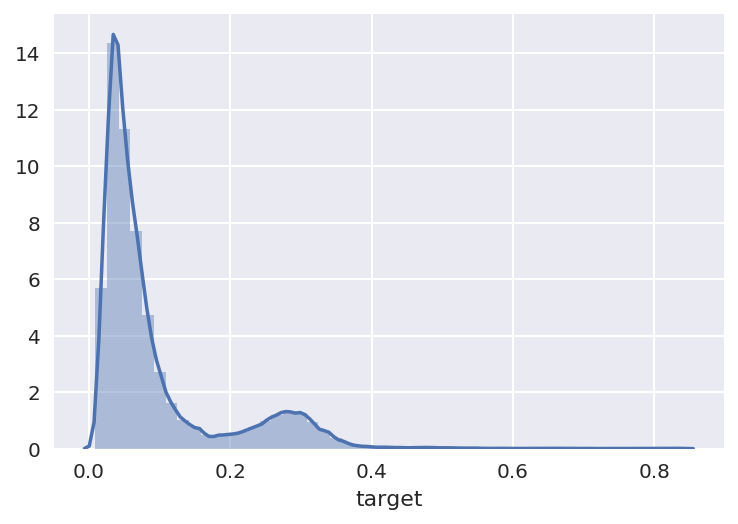

In [88]:
sns.distplot(proc_test[target_col])

In [89]:
proc_test[[id_col, target_col]].to_csv(SUBMISSIONS/'robert_5_submit_blend.csv', index=False)

## Catboost

In [91]:
proc_all[cat_cols+cont_cols].head()

,device,siteid,ADD_TO_BASKET_CAROUSEL_type,ADD_TO_BASKET_LP_type,ADD_TO_BASKET_LR_type,ADD_TO_BASKET_PA_type,ADD_TO_BASKET_SHOW_CASE_type,CAROUSEL_type,LIST_PRODUCT_type,PA_type,PRODUCT_CAROUSEL_type,PRODUCT_LP_type,PRODUCT_LR_type,PRODUCT_PA_type,PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_CAROUSEL_type,PURCHASE_PRODUCT_LP_type,PURCHASE_PRODUCT_LR_type,PURCHASE_PRODUCT_PA_type,PURCHASE_PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_UNKNOW_ORIGIN_type,SEARCH_type,SHOW_CASE_type,SUM_TYPE_type,ADD_TO_BASKET_sim_type,CAROUSEL_sim_type,LIST_PRODUCT_sim_type,PA_sim_type,PRODUCT_sim_type,PURCHASE_PRODUCT_sim_type,SEARCH_sim_type,SHOW_CASE_sim_type,SUM_TYPE_SIMPLIFIED_sim_type,TOTAL_DURATION,rh,rw
0,1,2,-0.13629,-0.096032,-0.324686,-0.04274,-0.0539,-0.018022,-0.357963,-0.709923,-0.393418,-0.228171,1.311323,-0.169234,-0.17929,-0.030783,-0.017347,-0.065389,-0.011457,-0.012413,-0.077065,0.567681,-0.429121,-0.392211,-0.37517,-0.018022,-0.357963,-0.709923,0.715447,-0.098374,0.567681,-0.429121,-0.392211,0.303747,-0.387101,-0.023410
1,1,2,-0.13629,-0.096032,-0.324686,-0.04274,-0.0539,0.198550,-0.357963,-0.709923,0.495697,-0.228171,1.156799,-0.169234,-0.17929,-0.030783,-0.017347,-0.065389,-0.011457,-0.012413,-0.077065,0.192166,-0.429121,0.177035,-0.37517,0.198550,-0.357963,-0.709923,1.117191,-0.098374,0.192166,-0.429121,0.177035,-0.288667,-0.613114,-0.171287
2,1,2,-0.13629,-0.096032,-0.324686,-0.04274,-0.0539,-0.956499,-0.357963,0.898412,-0.393418,-0.228171,1.311323,-0.169234,-0.17929,-0.030783,-0.017347,-0.065389,-0.011457,-0.012413,-0.077065,0.567681,-0.429121,-0.392211,-0.37517,-0.956499,-0.357963,0.898412,0.715447,-0.098374,0.567681,-0.429121,-0.392211,-0.346481,-0.680307,-0.246735
3,1,2,-0.13629,-0.096032,-0.324686,-0.04274,-0.0539,-0.956499,-0.357963,-0.709923,-0.393418,-0.228171,-0.697493,-0.169234,-0.17929,-0.030783,-0.017347,-0.065389,-0.011457,-0.012413,-0.077065,2.194912,-0.429121,-0.392211,-0.37517,-0.956499,-0.357963,-0.709923,-1.025445,-0.098374,2.194912,-0.429121,-0.392211,-0.369580,0.266504,0.459455
4,1,2,-0.13629,-0.096032,-0.324686,-0.04274,-0.0539,-0.956499,-0.357963,-0.709923,-0.393418,-0.228171,-0.697493,-0.169234,-0.17929,-0.030783,-0.017347,-0.065389,-0.011457,-0.012413,-0.077065,2.194912,-0.429121,-0.455461,-0.37517,-0.956499,-0.357963,-0.709923,-1.025445,-0.098374,2.194912,-0.429121,-0.455461,-0.375680,-0.918537,-0.246735


In [93]:
proc_test[cat_cols+cont_cols].head()

,device,siteid,ADD_TO_BASKET_CAROUSEL_type,ADD_TO_BASKET_LP_type,ADD_TO_BASKET_LR_type,ADD_TO_BASKET_PA_type,ADD_TO_BASKET_SHOW_CASE_type,CAROUSEL_type,LIST_PRODUCT_type,PA_type,PRODUCT_CAROUSEL_type,PRODUCT_LP_type,PRODUCT_LR_type,PRODUCT_PA_type,PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_CAROUSEL_type,PURCHASE_PRODUCT_LP_type,PURCHASE_PRODUCT_LR_type,PURCHASE_PRODUCT_PA_type,PURCHASE_PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_UNKNOW_ORIGIN_type,SEARCH_type,SHOW_CASE_type,SUM_TYPE_type,ADD_TO_BASKET_sim_type,CAROUSEL_sim_type,LIST_PRODUCT_sim_type,PA_sim_type,PRODUCT_sim_type,PURCHASE_PRODUCT_sim_type,SEARCH_sim_type,SHOW_CASE_sim_type,SUM_TYPE_SIMPLIFIED_sim_type,TOTAL_DURATION,rh,rw
0,1,2,-0.13629,-0.096032,-0.324686,-0.04274,-0.0539,-0.956499,4.761396,-0.709923,-0.393418,-0.228171,-0.697493,-0.169234,-0.17929,-0.030783,-0.017347,-0.065389,-0.011457,-0.012413,-0.077065,-1.059550,-0.042400,0.366784,-0.37517,-0.956499,4.761396,-0.709923,-1.025445,-0.098374,-1.059550,-0.042400,0.366784,-0.331832,0.052708,0.338739
1,3,0,-0.13629,-0.096032,-0.324686,-0.04274,-0.0539,-0.956499,-0.357963,-0.709923,-0.393418,-0.228171,-0.697493,-0.169234,-0.17929,-0.030783,-0.017347,-0.065389,-0.011457,-0.012413,-0.077065,1.381297,1.117760,-0.392211,-0.37517,-0.956499,-0.357963,-0.709923,-1.025445,-0.098374,1.381297,1.117760,-0.392211,-0.358720,-0.778042,-1.278860
2,1,2,-0.13629,-0.096032,-0.324686,-0.04274,-0.0539,-0.956499,-0.357963,-0.709923,-0.393418,-0.228171,1.311323,-0.169234,-0.17929,-0.030783,-0.017347,-0.065389,-0.011457,-0.012413,-0.077065,1.381297,-0.429121,-0.392211,-0.37517,-0.956499,-0.357963,-0.709923,0.715447,-0.098374,1.381297,-0.429121,-0.392211,-0.323856,0.077142,-0.023410
3,1,2,-0.13629,-0.096032,-0.324686,-0.04274,-0.0539,-0.956499,-0.357963,0.898412,-0.393418,-0.228171,1.311323,-0.169234,-0.17929,-0.030783,-0.017347,-0.065389,-0.011457,-0.012413,-0.077065,0.567681,-0.429121,-0.392211,-0.37517,-0.956499,-0.357963,0.898412,0.715447,-0.098374,0.567681,-0.429121,-0.392211,-0.275748,-0.619222,-0.633028
4,1,2,-0.13629,-0.096032,-0.324686,-0.04274,-0.0539,0.294804,-0.357963,1.434523,-0.393418,-0.228171,-0.697493,-0.169234,-0.17929,-0.030783,-0.017347,-0.065389,-0.011457,-0.012413,-0.077065,-1.059550,1.633388,-0.455461,-0.37517,0.294804,-0.357963,1.434523,-1.025445,-0.098374,-1.059550,1.633388,-0.455461,-0.347836,1.708100,2.068001


In [111]:
import lightgbm as lgbm
from src.utils_j import generate_validation_set, test_lgbm

params = {
    'objective' :'binary',
    'max_depth' : 9,
    'num_leaves': 50,
    'min_child_samples': 10,
    'scale_pos_weight': 1.0,
    'subsample': 0.866999534037008,
    'colsample_bytree': 0.2,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.0459,
    'lambda_l2': 5.0,
    #'metric': 'binary_logloss',
    #'bagging_fraction': 0.5,
}

lgbm_test_preds = test_lgbm(lgbm, {'objective': 'binary'}, proc_all[cat_cols + cont_cols],
                                   proc_all[target_col], 
                                   proc_test[cat_cols + cont_cols], 
                                   test_size=0.15, 
                                   random_seeds=[3, 15, 42, 120, 300], 
                                   cat_features=[0, 1])[0]

No. estimators: 44 | Train log loss: 0.26114524593167293 | Val log loss: 0.2674443694812228
No. estimators: 39 | Train log loss: 0.2617120851006594 | Val log loss: 0.26991800536016025
No. estimators: 77 | Train log loss: 0.25474035778258086 | Val log loss: 0.2741001564696571
No. estimators: 54 | Train log loss: 0.25964288422485543 | Val log loss: 0.2673432582341888
No. estimators: 41 | Train log loss: 0.26066999414092107 | Val log loss: 0.27272728481098757

Train logloss: 25.96 +/- 0.50 | Val logloss: 27.03 +/- 0.55



In [115]:
from catboost import CatBoostClassifier
from src.utils_j import test_catboost

In [118]:
catboost_test_preds = test_catboost(CatBoostClassifier(iterations=1000, 
                                    random_seed=42, eval_metric='Logloss'), 
                                    proc_all[cat_cols + cont_cols],
                                   proc_all[target_col], 
                                   proc_test[cat_cols + cont_cols], 
                                   test_size=0.15, 
                                   random_seeds=[5, 17, 45, 125, 305], 
                                   cat_features=[0, 1])[0]

No. estimators: 135 | Train log loss: 0.26149121865998737 | Val log loss: 0.2683198607922001
No. estimators: 118 | Train log loss: 0.2634392523282075 | Val log loss: 0.2619176321374138
No. estimators: 138 | Train log loss: 0.26197509730244506 | Val log loss: 0.2652024811440374
No. estimators: 110 | Train log loss: 0.2613553545089968 | Val log loss: 0.2761651088223681
No. estimators: 193 | Train log loss: 0.25830175189378357 | Val log loss: 0.2715194585201963

Train logloss: 26.13 +/- 0.34 | Val logloss: 26.86 +/- 0.99



In [119]:
proc_test[target_col] = catboost_test_preds

In [120]:
proc_test[[id_col, target_col]].to_csv(SUBMISSIONS/'robert_6_submit_catboost.csv', index=False)

In [ ]:
model.load_state_dict(torch.load(f'data/neuralnet/model_e{best_epoch}.pt'))

In [ ]:
from src.utils_r import MultimodalDataset
from torch.utils.data import DataLoader

def get_data(proc_all, proc_test, duration_seqs_train, action_seqs_train):
    train_cat_seqs, test_cat_seqs = get_cat_seqs(events_fixed_seq, proc_all, 
                                            proc_test)
    train_cont_seqs, test_cont_seqs = get_cont_seqs([duration_seqs_train, 
                                 action_seqs_train,
                                 quantity_seqs_train], [duration_seqs_test,
                                 action_seqs_test, quantity_seqs_test],
                                 seqs_train_dict, seqs_test_dict, 
                                 proc_all, proc_test)
    process_cats(proc_all, proc_test, cat_cols)
    scale_conts(proc_all, proc_test, cont_cols)
    

    ds_trn = MultimodalDataset(proc_all[cat_cols], proc_all[cont_cols],
                               train_cat_seqs, train_cont_seqs, proc_all[target_col])
    ds_val = MultimodalDataset(proc_test[cat_cols], proc_test[cont_cols],
                               test_cat_seqs, test_cont_seqs, proc_test[target_col])
    
    dl_trn = DataLoader(ds_trn, batch_size=128, shuffle=True)
    dl_val = DataLoader(ds_val, batch_size=128)
    
    

In [122]:
sub5 = pd.read_csv(SUBMISSIONS/'robert_5_submit_blend.csv')